In [9]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import grad, jit, vmap
from jax import random


%load_ext snakeviz

@jit
def psi(coords):
    return jnp.exp(-jnp.sum(coords**2)/2)

def sample_test(num_samples=10**3, thermalization_steps=200, skip_count=50, variation_size=1.0):
    outputs = []
    num_accepted = 0
    num_total = num_samples*skip_count + thermalization_steps + 1
    rand_coords = np.random.uniform(-variation_size, variation_size, size=(num_total, 2))
    rand_accepts = np.random.uniform(0, 1, size=num_total)

    coords_t = jnp.zeros(2)
    for step in range(num_total):
        coords_t, accepted = sample_body_test(coords_t, step, rand_coords, rand_accepts)
        if accepted:
            num_accepted += 1
        if ((step > thermalization_steps) and (step % skip_count == 0)):
            outputs.append(coords_t)
    # create a second output array, where the second coordinate is equal to the first coordinate
    outputs_prime = outputs
    for i in range(len(outputs)):
        a = outputs[i]
        a.at[1].set(a[0])
        outputs_prime[i] = a
    return jnp.array(outputs), jnp.array(outputs_prime), num_accepted/num_total

@jit
def sample_body_test(coords_t, step_index, rand_coords, rand_accepts):    
    coords_prime = coords_t + rand_coords[step_index]
    return jax.lax.cond(rand_accepts[step_index] < psi(coords_prime)/psi(coords_t), lambda x,_: (x,True) , lambda _,y: (y,False), coords_prime, coords_t) 

The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


In [16]:
# %%snakeviz -t

variation = 1.8
samples, _, ratio = sample_test(num_samples=10**4, thermalization_steps=200, skip_count=50, variation_size=variation)
print(ratio)


0.5038174653789177


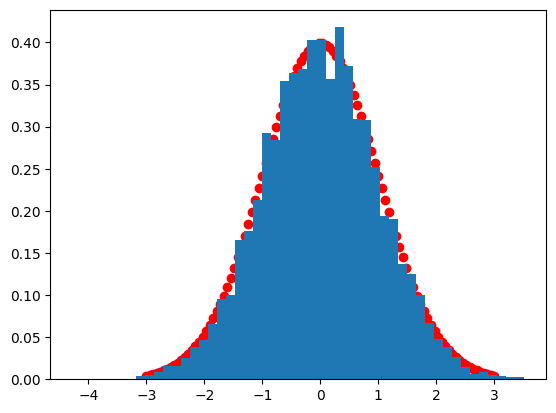

In [17]:
xs = samples[:,0]
def true(x):
    return np.sqrt(1/(2 * np.pi)) * np.exp(-x**2/2)
    # return 0.463835 * np.exp(-x**4/2)
x = np.linspace(-3, 3, 100)
plt.scatter(x, true(x), color='red')
plt.hist(xs, bins=50, density=True)
plt.show()

In [18]:
temp = [coord[0]**2 + coord[1]**2 for coord in samples]
print(np.mean(temp))
print(np.std(temp)/np.sqrt(len(temp)))

1.9742994
0.02023334741592407
